# 1. Data Wrangling and EDA for Capstone Three<a id='1_Data_wrangling_eda'></a>

## 1.1 Contents<a id='1.1_Contents'></a>

* [1. Data Wrangling and EDA](#1_Data_wrangling_eda)
    * [1.1 Contents](#1.1_Contents)
    * [1.2 Introduction](#1.2_Introduction)
    * [1.3 Imports](#1.3_Imports)
        * [1.3.1 Import packages](#1.3.1_import_packages)
        * [1.3.2 Access Twitter API](#1.3.2_twitter_api)
        * [1.3.3 Download JD Tweets](#1.3.3_jd_tweets)
        * [1.3.4 Download S&P 500 Tweets](#1.3.4_sp_tweets)
        * [1.3.5 Access Yahoo API](#1.3.5_yahoo_api)
        * [1.3.6 Access Twitter API](#1.3.2_twitter_api)
    * [2.1 Explore datasets](#2.1_explore_data)
        * [2.1.1 JD Twitter Data](#2.1.1_jd_twitter)
            * [2.1.1.1 JD Twitter Sentiment Analysis](#2.1.1.1_jd_twitter_sentiment)
        * [2.1.2 SP500 Twitter Data](#2.1.2_sp_twitter)
            * [2.1.2.1 SP500 Twitter Sentiment Analysis](#2.1.2.1_sp_twitter_sentiment)
        * [2.1.3 JD Stock Price Data](#2.1.3_jd_price)
            * [2.1.3.1 JD Time Series Feature Engineering](#2.1.3.1_jd_ts_feature_eng)
        * [2.1.4 SP500 Stock Price Data](#2.1.4_sp_price)
            * [2.1.4.1 SP500 Time Series Feature Engineering](#2.1.4.1_sp_ts_feature_eng)
        
    
    
        

## 1.2 Introduction  <a id='1.2_Introduction'></a>

The purpose of this capstone project is to develop a model to predict stock movements, either predict stock price level, or identify positive or negative movements. More specifically we'd like to identify when the market might turn.

To accomplish this we will leverage twitter data to perform sentiment analysis on the SP500 index and the JD.com stock. We would then like to combine this with time series data for these two investment vehicles to see if we can make any meaningful predictions.

One constraint we have is that the Twitter data does not look back so I need to download data every day. We may need to download data for at least 30 trading days before we have enough data to establish meaningful relationships with stock price. For the purposes of this capstone, we will use what data we can obtain, knowing that we will need to iterate on this model once we get more data in the future.

## 1.3 Import Data From Twitter<a id='1.3_Imports'></a>

### 1.3.1 Import packages<a id='1.3.1_import_packages'></a>

In [1]:
#!pip install tweepy    # Installed this package on August 24 2021
#! pip install yfinance==0.1.63 # installed new version on August 25 2021
import re
import tweepy, json
import pandas as pd
import numpy as np
import os
import yfinance as yf
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psycopg2
import datetime as dt
from dateutil.parser import parse
import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

In [43]:
pip list

Package                            Version            
---------------------------------- -------------------
aiobotocore                        1.3.3              
aiohttp                            3.7.4.post0        
aioitertools                       0.7.1              
alabaster                          0.7.12             
alembic                            1.7.1              
anaconda-client                    1.7.2              
anaconda-navigator                 1.9.12             
anaconda-project                   0.8.3              
apache-airflow                     1.10.10            
apispec                            1.3.3              
applaunchservices                  0.2.1              
appnope                            0.1.0              
appscript                          1.0.1              
arch                               5.0.1              
argcomplete                        1.12.3             
argh                               0.26.2             
asn1crypto

Note: you may need to restart the kernel to use updated packages.


### 1.3.2 Access Twitter with API<a id='1.3.2_twitter_api'></a>

In [511]:
# Assign keys obtained from Twitter

access_token = ''
access_token_secret = ''
consumer_key = ''
consumer_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [2]:
# Assign keys obtained from Twitter

access_token = '1430161145311150080-Ha8nY3LbOwlQ7P27fZsYrwnNm6YOxq'
access_token_secret = 'fUP44yQLzb3FfsRqQE7rFtBVUqJIR4whksVTA2j19Zses'
consumer_key = 'ugxDeMXFmTPlKDaTZmoeLB3oS'
consumer_secret = 'yUfEyw8YGx0RrrE4JyGvhwKIBzRteJzLmL8rhIYunjdG1uGBCp'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

Resources:

* We want to use the User Mention Timeline API. Details found here https://developer.twitter.com/en/portal/products
* Another resource is the analyzing-social-media-data-in-python course in DataCamp.
* https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

### 1.3.3 Download tweets for JD.com<a id='1.3.3_jd_tweets'></a>

In [79]:
# Define the search term and the date_since date as variables

search_words = 'JD.com -filter:retweets'
date_since = '2021-11-04'

In [80]:
# Collect tweets

tweets = tweepy.Cursor(api.search, q=search_words, lang='en', result_type = 'mixed',since=date_since).items(500)

**Lets create a list comprehension function that will pull data and convert to a dataframe**

In [81]:
tweet_data = [[tweet.created_at, tweet.text, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

In [82]:
tweet_df = pd.DataFrame(tweet_data, columns = ['created_at', 'text', 'retweet_count', 'favourite_count'])

In [83]:
tweet_df.head()

,created_at,text,retweet_count,favourite_count
0,2021-11-03 18:09:50,"Ant Group, Tencent, https://t.co/yCxtuMNJCI Si...",0,0
1,2021-11-03 17:35:32,Live commerce is the mega trend for 2022. Chin...,0,0
2,2021-11-03 15:03:37,【OFFICIAL】\n\n#陈卓璇 | #ChenZhuoxuan\n\n• Hisens...,23,43
3,2021-11-03 13:30:39,$BBBY Telsey Advisory Group Maintains Market P...,0,1
4,2021-11-03 12:00:19,$JD [https://t.co/Fu7kVyruTK]: Barclays Initia...,0,0


In [71]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   created_at       16 non-null     datetime64[ns]
 1   text             16 non-null     object        
 2   retweet_count    16 non-null     int64         
 3   favourite_count  16 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 640.0+ bytes


In [84]:
# Export JD tweets to excel. Comment this code out so we don't overrite previously downloaded data

#tweet_df.to_csv('./twitter_data/JD_11042021.csv', index=False)

In [86]:
# Define the search term and the date_since date as variables

search_words_sp = 'SP500 -filter:retweets'
date_since_sp = '2021-11-04'

In [87]:
# Collect tweets

tweets_sp = tweepy.Cursor(api.search, q=search_words_sp, lang='en', result_type = 'mixed',since=date_since_sp).items(500)

In [88]:
tweet_data_sp = [[tweet.created_at, tweet.text, tweet.retweet_count, tweet.favorite_count] for tweet in tweets_sp]

In [89]:
tweet_df_sp = pd.DataFrame(tweet_data_sp, columns = ['created_at', 'text', 'retweet_count', 'favourite_count'])

In [90]:
tweet_df_sp.head()

,created_at,text,retweet_count,favourite_count
0,2021-11-03 20:14:43,"📈Market Conditions Today📉\n\n#DJI ⬆️ .29%💲36,1...",5,21
1,2021-11-03 21:44:26,"lol, where are the bears? :D #dowjones #stocks...",0,0
2,2021-11-03 21:43:00,Traditional analysis is out of touch #artific...,0,0
3,2021-11-03 21:35:30,"Today's #sp500 high is its 62nd of the year, m...",0,0
4,2021-11-03 21:28:51,@VinetSharma3 @CNBC SP500 and Nasdaq new recor...,0,0


In [91]:
# Export SP500 tweets to excel. Comment this code out so we don't overrite previously downloaded data

#tweet_df_sp.to_csv('./twitter_data/SP_11042021.csv', index=False)

**Instructions**

Need to run the API call for JD.com and SP everyday after at 4:30pm to ensure we capture all information that happened during the trading day.

### 1.3.4 Access Yahoo API<a id='1.3.5_yahoo_api'></a>

In [525]:
# create function that downloads stock price from yahoo finance


def yahoo_stock_dl(stockList, progress = True):
    ''' function to download stock prices form yahoo finance.
    
    Inputs:
    
    stockList -> is a list of stock ticker symbols to download.
    startDate -> start date of time series
    endDate -> end date of time series
    
    Output:
    
    exports dataframe of stock price into working directory
    '''
    stockList = stockList
    for stock in stockList:
        
        time.sleep(1)
    
        df = yf.download(tickers=stock, start = '2019-01-01', end = '2021-09-01', progress = False)

        with pd.ExcelWriter('{name}.xlsx'.format(name=stock)) as writer:
            df.to_excel(writer, 'Sheet1')        


    

In [526]:
# Download stock price data and then exportit. May need to re-run to get new daily data

yahoo_stock_dl(['JD', 'SPY'])

Resources for working with Datetime:

https://towardsdatascience.com/mastering-dates-and-timestamps-in-pandas-and-python-in-general-5b8c6edcc50c

**Important Notes**

We have now created a pipeline to download twitter data on JD and the S&P 500. We also have downloaded daily stock data for JD and SPY (SPY is an ETF that tracks the S&P 500)

In the next few weeks we will need to continue to download twitter data on a daily basis at 4:30pm. This daily data will allow us to perform sentiment analysis for each day and give us a time series sentiment trend for each stock.



## 2.1 Explore Datasets<a id='2.1_explore_data'></a>

### 2.1.1 JD Twitter data<a id='2.1.1_jd_twitter'></a>

In [527]:
jd_twitter = pd.read_csv('./twitter_data/JD_8242021.csv')

In [528]:
# Have a look at the data.

jd_twitter

,created_at,text,retweet_count,favourite_count
0,2021-08-24 07:34:22,Chinese tech stocks rally as https://t.co/l0RH...,21,52
1,2021-08-25 10:34:17,"""We swapped out of other names that continue t...",4,19
2,2021-08-25 15:03:34,$MF: Missfresh Ltd. sales on https://t.co/uhas...,0,0
3,2021-08-25 14:48:46,WSJmarkets: Shares of Pinduoduo and https://t....,0,0
4,2021-08-25 14:45:06,Shares of Pinduoduo and https://t.co/XrmiDqOQQ...,3,8
...,...,...,...,...
489,2021-08-17 10:55:46,*MELVIN CAPITAL TAKES NEW STAKES IN https://t....,0,1
490,2021-08-17 10:52:01,*MELVIN CAPITAL TAKES NEW STAKES IN https://t....,14,39
491,2021-08-17 09:14:35,Leading the new fashion of electrical consumpt...,0,0
492,2021-08-17 09:10:21,Redmi K40 Gaming Edition Teased in New Inverse...,0,0


In [529]:
jd_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   created_at       494 non-null    object
 1   text             494 non-null    object
 2   retweet_count    494 non-null    int64 
 3   favourite_count  494 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.6+ KB


In [530]:
jd_twitter['date'] = jd_twitter['created_at'].apply(lambda x : parse(x))

In [531]:
jd_twitter['month'] = jd_twitter['date'].dt.month
jd_twitter['week'] = jd_twitter['date'].dt.week
jd_twitter['day'] = jd_twitter['date'].dt.day

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [532]:
jd_twitter.head()

,created_at,text,retweet_count,favourite_count,date,month,week,day
0,2021-08-24 07:34:22,Chinese tech stocks rally as https://t.co/l0RH...,21,52,2021-08-24 07:34:22,8,34,24
1,2021-08-25 10:34:17,"""We swapped out of other names that continue t...",4,19,2021-08-25 10:34:17,8,34,25
2,2021-08-25 15:03:34,$MF: Missfresh Ltd. sales on https://t.co/uhas...,0,0,2021-08-25 15:03:34,8,34,25
3,2021-08-25 14:48:46,WSJmarkets: Shares of Pinduoduo and https://t....,0,0,2021-08-25 14:48:46,8,34,25
4,2021-08-25 14:45:06,Shares of Pinduoduo and https://t.co/XrmiDqOQQ...,3,8,2021-08-25 14:45:06,8,34,25


In [533]:
jd_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   created_at       494 non-null    object        
 1   text             494 non-null    object        
 2   retweet_count    494 non-null    int64         
 3   favourite_count  494 non-null    int64         
 4   date             494 non-null    datetime64[ns]
 5   month            494 non-null    int64         
 6   week             494 non-null    int64         
 7   day              494 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 31.0+ KB


(array([488.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  11.4,  22.8,  34.2,  45.6,  57. ,  68.4,  79.8,  91.2,
        102.6, 114. ]),
 [<matplotlib.patches.Polygon at 0x7fbab1771b90>])

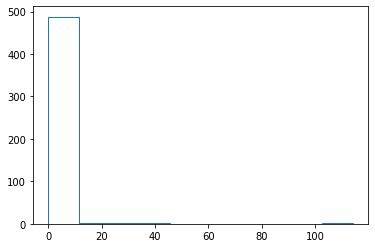

In [534]:
plt.hist(jd_twitter['retweet_count'], histtype='step')

**Majority of tweets have very low retweets**

(array([487.,   4.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0. ,  27.4,  54.8,  82.2, 109.6, 137. , 164.4, 191.8, 219.2,
        246.6, 274. ]),
 [<matplotlib.patches.Polygon at 0x7fbab1eb7f10>])

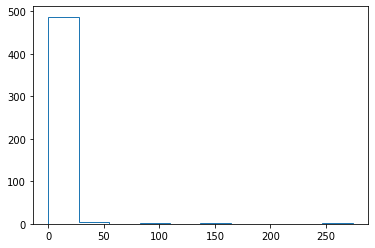

In [535]:
plt.hist(jd_twitter['favourite_count'], histtype='step')

**Majority of tweets have not been favourited**

#### 2.1.1.1 JD Twitter Sentiment Analysis<a id='2.1.1.1_jd_twitter_sentiment'></a>

In [536]:
sid = SentimentIntensityAnalyzer()
sentiment_score = jd_twitter['text'].apply(sid.polarity_scores)

In [537]:
jd_twitter['sentiment'] = sentiment_score.apply(lambda x : x['compound'])
jd_twitter.head()

,created_at,text,retweet_count,favourite_count,date,month,week,day,sentiment
0,2021-08-24 07:34:22,Chinese tech stocks rally as https://t.co/l0RH...,21,52,2021-08-24 07:34:22,8,34,24,0.000
1,2021-08-25 10:34:17,"""We swapped out of other names that continue t...",4,19,2021-08-25 10:34:17,8,34,25,0.000
2,2021-08-25 15:03:34,$MF: Missfresh Ltd. sales on https://t.co/uhas...,0,0,2021-08-25 15:03:34,8,34,25,0.000
3,2021-08-25 14:48:46,WSJmarkets: Shares of Pinduoduo and https://t....,0,0,2021-08-25 14:48:46,8,34,25,0.296
4,2021-08-25 14:45:06,Shares of Pinduoduo and https://t.co/XrmiDqOQQ...,3,8,2021-08-25 14:45:06,8,34,25,0.296


### 2.1.2 SP500 Twitter data<a id='2.1.2_sp_twitter'></a>

In [538]:
sp_twitter = pd.read_csv('./twitter_data/SP_8242021.csv')

In [539]:
# Have a look at the data.

sp_twitter

,created_at,text,retweet_count,favourite_count
0,2021-08-24 21:52:06,"The Nasdaq surpassed the 15,000 level for the ...",34,163
1,2021-08-25 09:31:14,US stock futures tread water after S&amp;P 500...,9,14
2,2021-08-25 15:30:06,Join me &amp; my @cfraresearch colleagues for ...,0,0
3,2021-08-25 15:24:51,@MacroAlf @CyberSpaceGal Based on Pe ratios of...,0,0
4,2021-08-25 15:22:56,Excess fiscal and #FederalReserve pumped liqui...,0,1
...,...,...,...,...
495,2021-08-23 15:07:12,"Paysafe $PSFE\n\nBlock of 43,639 shares at $8....",1,3
496,2021-08-23 15:04:28,"@ben_golub @arpitrage You can even read ""skew""...",0,6
497,2021-08-23 15:03:20,"Ford Motor $F\n\nBlock of 241,170 shares at $1...",0,2
498,2021-08-23 15:02:07,"$AMC\n\nAnother block of 29,380 shares at $36....",3,7


In [540]:
sp_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   created_at       500 non-null    object
 1   text             500 non-null    object
 2   retweet_count    500 non-null    int64 
 3   favourite_count  500 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


In [541]:
sp_twitter['date'] = sp_twitter['created_at'].apply(lambda x : parse(x))

In [542]:
sp_twitter['month'] = sp_twitter['date'].dt.month
sp_twitter['week'] = sp_twitter['date'].dt.week
sp_twitter['day'] = sp_twitter['date'].dt.day

/Users/davidlam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [543]:
sp_twitter.head()

,created_at,text,retweet_count,favourite_count,date,month,week,day
0,2021-08-24 21:52:06,"The Nasdaq surpassed the 15,000 level for the ...",34,163,2021-08-24 21:52:06,8,34,24
1,2021-08-25 09:31:14,US stock futures tread water after S&amp;P 500...,9,14,2021-08-25 09:31:14,8,34,25
2,2021-08-25 15:30:06,Join me &amp; my @cfraresearch colleagues for ...,0,0,2021-08-25 15:30:06,8,34,25
3,2021-08-25 15:24:51,@MacroAlf @CyberSpaceGal Based on Pe ratios of...,0,0,2021-08-25 15:24:51,8,34,25
4,2021-08-25 15:22:56,Excess fiscal and #FederalReserve pumped liqui...,0,1,2021-08-25 15:22:56,8,34,25


(array([490.,   5.,   2.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0. ,  5.6, 11.2, 16.8, 22.4, 28. , 33.6, 39.2, 44.8, 50.4, 56. ]),
 [<matplotlib.patches.Polygon at 0x7fba7984e5d0>])

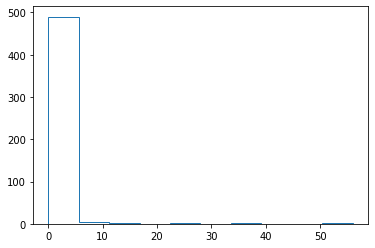

In [544]:
plt.hist(sp_twitter['retweet_count'], histtype='step')

**Majority of tweets have very low retweets**

(array([480.,  12.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  16.3,  32.6,  48.9,  65.2,  81.5,  97.8, 114.1, 130.4,
        146.7, 163. ]),
 [<matplotlib.patches.Polygon at 0x7fbaa3fcc390>])

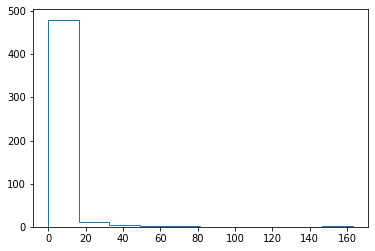

In [545]:
plt.hist(sp_twitter['favourite_count'], histtype='step')

**Majority of tweets have not been favourited**

#### 2.1.2.1 SP500 Twitter Sentiment Analysis<a id='2.1.2.1_sp_twitter_sentiment'></a>

In [546]:
sid = SentimentIntensityAnalyzer()
sentiment_score_sp = sp_twitter['text'].apply(sid.polarity_scores)
sp_twitter['sentiment'] = sentiment_score_sp.apply(lambda x : x['compound'])
sp_twitter.head()

,created_at,text,retweet_count,favourite_count,date,month,week,day,sentiment
0,2021-08-24 21:52:06,"The Nasdaq surpassed the 15,000 level for the ...",34,163,2021-08-24 21:52:06,8,34,24,0.7269
1,2021-08-25 09:31:14,US stock futures tread water after S&amp;P 500...,9,14,2021-08-25 09:31:14,8,34,25,0.0000
2,2021-08-25 15:30:06,Join me &amp; my @cfraresearch colleagues for ...,0,0,2021-08-25 15:30:06,8,34,25,0.2960
3,2021-08-25 15:24:51,@MacroAlf @CyberSpaceGal Based on Pe ratios of...,0,0,2021-08-25 15:24:51,8,34,25,0.4215
4,2021-08-25 15:22:56,Excess fiscal and #FederalReserve pumped liqui...,0,1,2021-08-25 15:22:56,8,34,25,-0.1513


### 2.1.3 JD Stock Price data<a id='2.1.3_jd_price'></a>

In [547]:
xl = pd.ExcelFile('JD.xlsx')
jd_price = xl.parse('Sheet1')
jd_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000
1,2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000
2,2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900
3,2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800
4,2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400


In [548]:
jd_price = jd_price.set_index('Date')
jd_price.sort_index(ascending=False).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-31,78.080002,80.559998,77.300003,78.559998,78.559998,13038300
2021-08-30,75.148003,76.968002,74.290001,76.690002,76.690002,7979900
2021-08-27,77.250000,78.120003,75.809998,76.430000,76.430000,12965300
2021-08-26,76.190002,77.473000,75.805000,77.040001,77.040001,11581100
2021-08-25,74.750000,76.300003,73.730003,76.139999,76.139999,11311900


<AxesSubplot:xlabel='Date'>

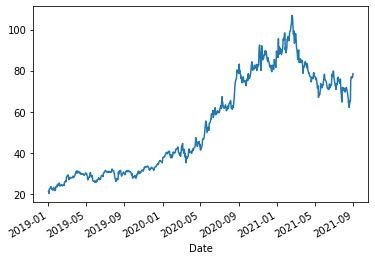

In [549]:
jd_price['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

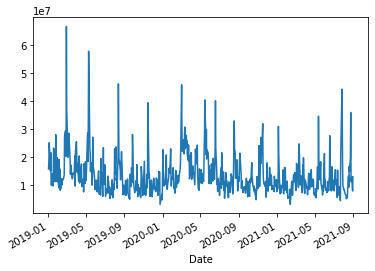

In [550]:
jd_price['Volume'].plot()

This is interesting. There appears to be cyclical spikes in volume. These spikes could be due to investitutional investor activity and hedging from dealers

In [551]:
# Lets look at the difference between the daily high and daily low

jd_price['high_minus_low'] = jd_price['High'] - jd_price['Low']
jd_price.head()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low
Date,,,,,,,
2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000,1.299999
2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000,0.889999
2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900,1.930000
2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800,0.590000
2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400,0.745001


(array([232., 184., 140.,  63.,  24.,  17.,   6.,   3.,   1.,   2.]),
 array([0.29500008, 1.11149998, 1.92799988, 2.74449978, 3.56099968,
        4.37749958, 5.19399948, 6.01049938, 6.82699928, 7.64349918,
        8.45999908]),
 [<matplotlib.patches.Polygon at 0x7fba79903a90>])

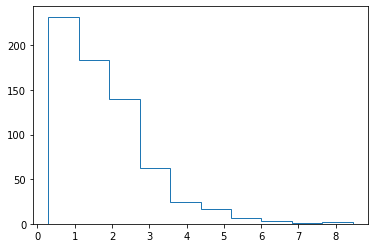

In [552]:
# Plot distribution of high_minus_low

plt.hist(jd_price['high_minus_low'], histtype='step')

In [553]:
# Lets create high_minus_low as a percentage of opening price to see if we get a different distribution

jd_price['high_minus_low_pct_open'] = (jd_price['High'] - jd_price['Low'])/jd_price['Open'] * 100
jd_price.head()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_open
Date,,,,,,,,
2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000,1.299999,6.400784
2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000,0.889999,4.260409
2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900,1.930000,9.199239
2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800,0.590000,2.630406
2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400,0.745001,3.240543


(array([225., 298.,  85.,  46.,   9.,   8.,   0.,   0.,   0.,   1.]),
 array([ 0.87818007,  2.51335311,  4.14852615,  5.78369918,  7.41887222,
         9.05404526, 10.68921829, 12.32439133, 13.95956437, 15.5947374 ,
        17.22991044]),
 [<matplotlib.patches.Polygon at 0x7fbac4397890>])

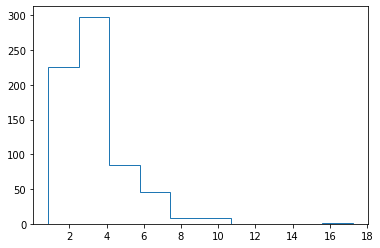

In [554]:
# Plot distribution of high_minus_low_pct

plt.hist(jd_price['high_minus_low_pct_open'], histtype='step')

<AxesSubplot:xlabel='Date'>

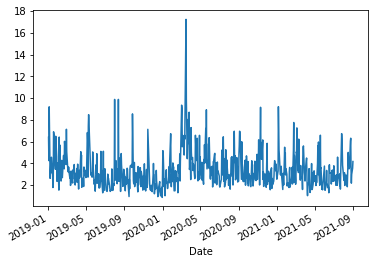

In [555]:
jd_price['high_minus_low_pct_open'].plot()

In [556]:
# Lets create high_minus_low as a percentage of Adj Close price to see if we get a different distribution

jd_price['high_minus_low_pct_adjclose'] = (jd_price['High'] - jd_price['Low'])/jd_price['Adj Close'] * 100
jd_price.head()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_open,high_minus_low_pct_adjclose
Date,,,,,,,,,
2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000,1.299999,6.400784,6.111891
2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000,0.889999,4.260409,4.373461
2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900,1.930000,9.199239,8.666369
2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800,0.590000,2.630406,2.592268
2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400,0.745001,3.240543,3.246191


(array([241., 288.,  86.,  42.,   9.,   5.,   0.,   0.,   0.,   1.]),
 array([ 0.87992496,  2.55697137,  4.23401778,  5.91106419,  7.5881106 ,
         9.26515702, 10.94220343, 12.61924984, 14.29629625, 15.97334266,
        17.65038907]),
 [<matplotlib.patches.Polygon at 0x7fbac4483a50>])

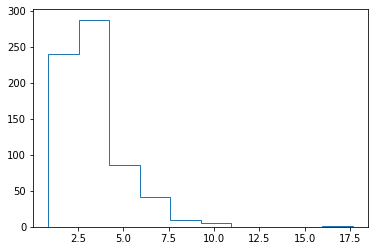

In [557]:
# Plot distribution of high_minus_low_pct

plt.hist(jd_price['high_minus_low_pct_adjclose'], histtype='step')

<AxesSubplot:xlabel='Date'>

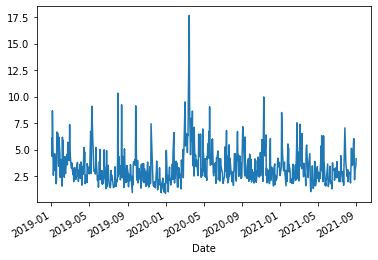

In [558]:
jd_price['high_minus_low_pct_adjclose'].plot()

There isn't much of a difference between open and close so we will go with adjclose since we need to wait for the day to finish anyways to get the high and low metric

In [559]:
jd_price = jd_price.drop('high_minus_low_pct_open', axis=1)

#### 2.1.3.1 JD Time Series Feature Engineering<a id='2.1.3.1_jd_ts_feature_eng'></a>

In [560]:
jd_price['lagged_1'] = jd_price['Adj Close'].shift(-1)     # create 1 day lag variable
jd_price['lagged_5'] = jd_price['Adj Close'].shift(-5)     # create 5 day lag variable
jd_price['lagged_10'] = jd_price['Adj Close'].shift(-10)   # create 10 day lag variable
jd_price['lagged_20'] = jd_price['Adj Close'].shift(-20)   # create 20 day lag variable

# Create shifted variables

jd_price['shifted_1'] = jd_price['Adj Close'].shift(1)     # create 1 day shifted variable
jd_price['shifted_5'] = jd_price['Adj Close'].shift(5)     # create 5 day shifted variable
jd_price['shifted_10'] = jd_price['Adj Close'].shift(10)   # create 10 day shifted variable
jd_price['shifted_20'] = jd_price['Adj Close'].shift(20)   # create 20 day shifted variable

# Calculate returns

jd_price['pct_change_1'] = jd_price['Adj Close'].pct_change(1).mul(100)     
jd_price['pct_change_5'] = jd_price['Adj Close'].pct_change(5).mul(100)     
jd_price['pct_change_10'] = jd_price['Adj Close'].pct_change(10).mul(100)   
jd_price['pct_change_20'] = jd_price['Adj Close'].pct_change(20).mul(100)

# Rolling window metrics, these moving averages are typically important to technical traders

jd_price['50_ma'] = jd_price['Adj Close'].rolling(window=50).mean()
jd_price['100_ma'] = jd_price['Adj Close'].rolling(window=100).mean()
jd_price['200_ma'] = jd_price['Adj Close'].rolling(window=200).mean()

# Rolling window metrics, moving standard deviation 

jd_price['50_std'] = jd_price['Adj Close'].rolling(window=50).std()
jd_price['100_std'] = jd_price['Adj Close'].rolling(window=100).std()
jd_price['200_std'] = jd_price['Adj Close'].rolling(window=200).std()

# Cumulative return

jd_price['cumulative_return'] = jd_price['Adj Close'].pct_change(1).add(1).cumprod().sub(1).mul(100)

In [561]:
jd_price.head()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_adjclose,lagged_1,lagged_5,...,pct_change_5,pct_change_10,pct_change_20,50_ma,100_ma,200_ma,50_std,100_std,200_std,cumulative_return
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,20.309999,21.480000,20.180000,21.270000,21.270000,15840000,1.299999,6.111891,20.350000,23.690001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,20.889999,21.139999,20.250000,20.350000,20.350000,18608000,0.889999,4.373461,22.270000,23.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.325341
2019-01-04,20.980000,22.680000,20.750000,22.270000,22.270000,25156900,1.930000,8.666369,22.760000,22.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.701457
2019-01-07,22.430000,22.850000,22.260000,22.760000,22.760000,18889800,0.590000,2.592268,22.950001,22.040001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.005170
2019-01-08,22.990000,23.180000,22.434999,22.950001,22.950001,15180400,0.745001,3.246191,23.690001,22.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.898450


In [562]:
# create function to flag up days and down days

def up_down_days(x):
    if x >= 0:
        return 'UP'
    else: 
        return 'DOWN'

In [563]:
jd_price['up_or_down'] = jd_price['pct_change_1'].apply(lambda x: up_down_days(x))
pd.concat([jd_price['up_or_down'].value_counts(), jd_price['up_or_down'].value_counts()/jd_price['up_or_down'].value_counts().sum()], axis=1) 

,up_or_down,up_or_down
UP,357,0.53125
DOWN,315,0.46875


There have been more up days than down days but it's pretty close. What matters is the magnitude of the up and down days

We would like to create a column that counts the consecutive up and down days. We can use this to get a distribution of the consecutive up days and down days for JD.com

In [564]:
# create column with count of consecutive up and down days

jd_price['consecutive_count'] = jd_price.groupby((jd_price['up_or_down'] != jd_price['up_or_down'].shift(1)).cumsum()).cumcount() + 1

<AxesSubplot:>

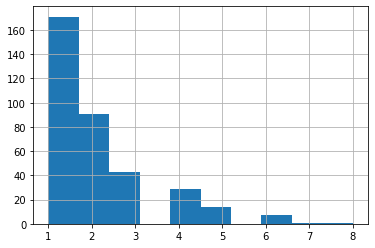

In [565]:
jd_price.loc[jd_price['up_or_down'] == 'UP', 'consecutive_count'].hist()

We need to count the number of consecuribe days without double counting. For example a day consecutive gain, will have a day with 1 and 2 which means 1 is double counted. Need to find a way to remove this.

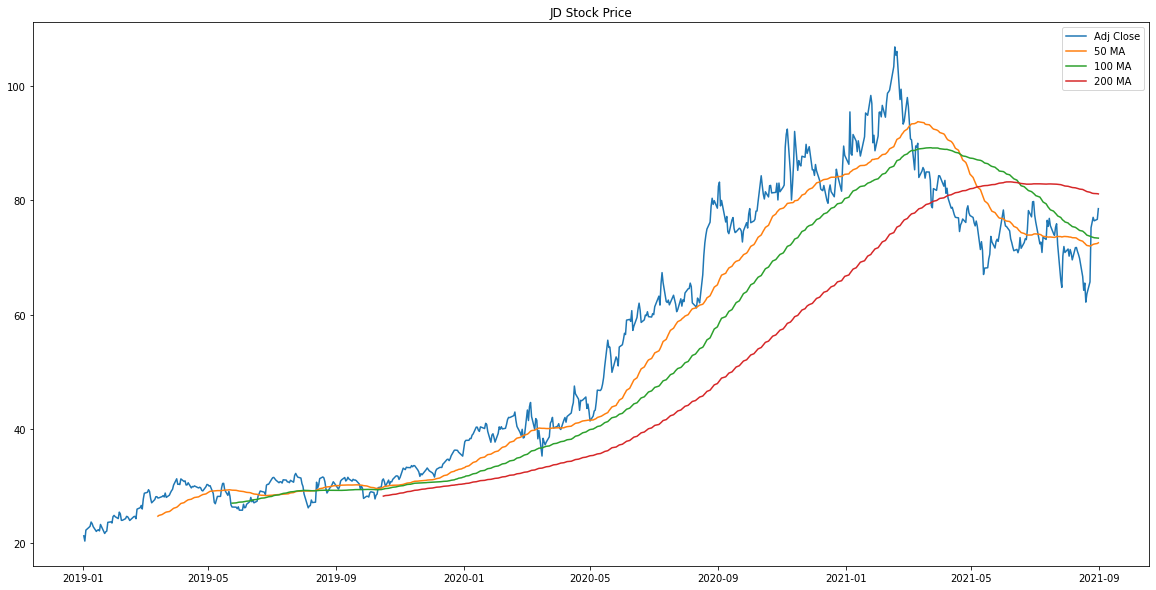

In [566]:
# Plot price vs moving averages
plt.figure(figsize=(20,10))

plt.plot(jd_price[['Adj Close', '50_ma', '100_ma', '200_ma']])
plt.title('JD Stock Price')
plt.legend(['Adj Close', '50 MA', '100 MA', '200 MA'])

Here we see that when the 50 day moving average crosses below the 100 day we can see a dip in price. In fact the 100 day moving average crossed below the 200 day moving average in June of 2021. This is known as the death cross and is thought to signal further down performance. WHen we look further down at the S&P we can see this isn't always the case as when the 100 day moving average crossed below the 200 day moving average, the recovery was already on it's way. So the speed of recovery will impact this signal. 

For JD it may appear that this is not on the way to recovery though.

In [567]:
jd_price.tail()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_adjclose,lagged_1,lagged_5,...,pct_change_20,50_ma,100_ma,200_ma,50_std,100_std,200_std,cumulative_return,up_or_down,consecutive_count
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-25,74.750000,76.300003,73.730003,76.139999,76.139999,11311900,2.570000,3.375361,77.040001,NaN,...,8.338077,72.1916,73.5822,81.26795,4.113754,4.102907,9.386763,257.968960,UP,4
2021-08-26,76.190002,77.473000,75.805000,77.040001,77.040001,11581100,1.667999,2.165108,76.430000,NaN,...,7.104130,72.3026,73.5175,81.22885,4.168943,3.994348,9.388013,262.200279,UP,5
2021-08-27,77.250000,78.120003,75.809998,76.430000,76.430000,12965300,2.310005,3.022380,76.690002,NaN,...,7.830140,72.3612,73.4693,81.21060,4.206540,3.928639,9.393803,259.332387,DOWN,1
2021-08-30,75.148003,76.968002,74.290001,76.690002,76.690002,7979900,2.678001,3.491982,78.559998,NaN,...,7.273751,72.4626,73.4148,81.17985,4.249200,3.844031,9.398507,260.554776,UP,1
2021-08-31,78.080002,80.559998,77.300003,78.559998,78.559998,13038300,3.259995,4.149688,NaN,NaN,...,11.845102,72.5814,73.3963,81.14075,4.335842,3.814362,9.393030,269.346478,UP,2


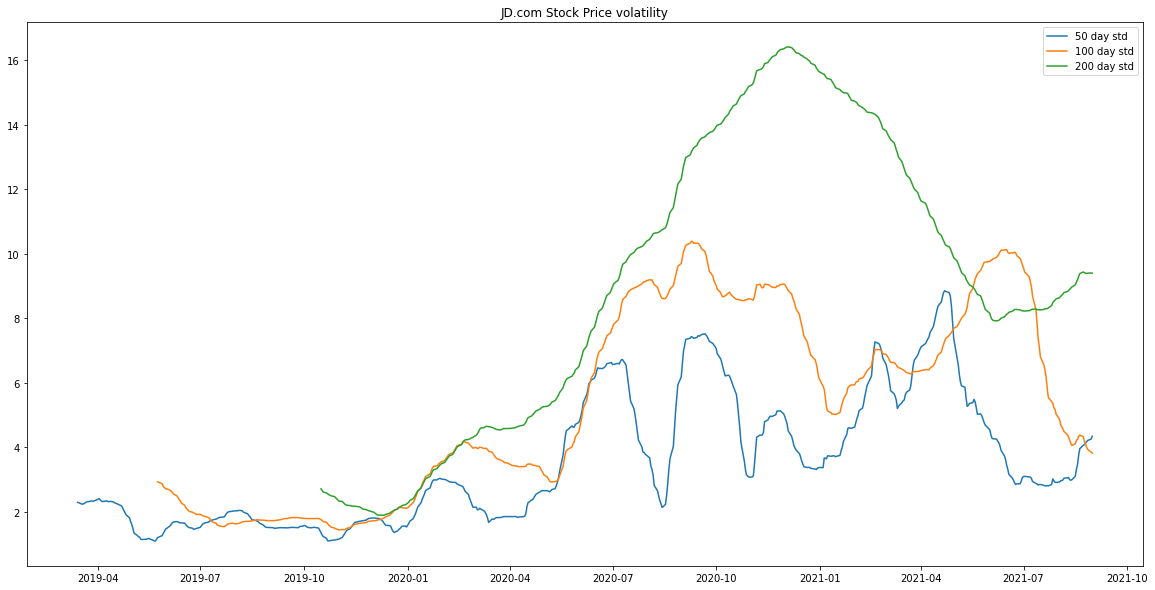

In [568]:
# Plot price vs moving averages
plt.figure(figsize=(20,10))

plt.plot(jd_price[['50_std', '100_std', '200_std']])
plt.title('JD.com Stock Price volatility')
plt.legend(['50 day std', '100 day std', '200 day std'])

In [569]:
# export jd_price

jd_price.to_csv('jd_price.csv')

### 2.1.4 SP500 Stock Price data<a id='2.1.4_sp_price'></a>

In [570]:
xl = pd.ExcelFile('SPY.xlsx')
sp_price = xl.parse('Sheet1')
sp_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,245.979996,251.210007,245.949997,250.179993,239.459229,126925200
1,2019-01-03,248.229996,248.570007,243.669998,244.210007,233.745056,144140700
2,2019-01-04,247.589996,253.110001,247.169998,252.389999,241.574493,142628800
3,2019-01-07,252.690002,255.949997,251.690002,254.380005,243.479263,103139100
4,2019-01-08,256.820007,257.309998,254.000000,256.769989,245.766846,102512600


In [571]:
sp_price = sp_price.set_index('Date')

In [572]:
sp_price.sort_index(ascending=False)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-31,452.130005,452.489990,450.920013,451.559998,451.559998,59246900
2021-08-30,450.970001,453.070007,450.709991,452.230011,452.230011,48357400
2021-08-27,447.119995,450.649994,447.059998,450.250000,450.250000,77201900
2021-08-26,448.609985,448.859985,446.160004,446.260010,446.260010,57829600
2021-08-25,448.170013,449.459991,447.769989,448.910004,448.910004,40529700
...,...,...,...,...,...,...
2019-01-08,256.820007,257.309998,254.000000,256.769989,245.766846,102512600
2019-01-07,252.690002,255.949997,251.690002,254.380005,243.479263,103139100
2019-01-04,247.589996,253.110001,247.169998,252.389999,241.574493,142628800


In [573]:
start_date = '2021-05-31'
start_date = pd.to_datetime(start_date)

In [574]:
end_date = start_date + pd.DateOffset(days=92)
end_date

Timestamp('2021-08-31 00:00:00')

<AxesSubplot:xlabel='Date'>

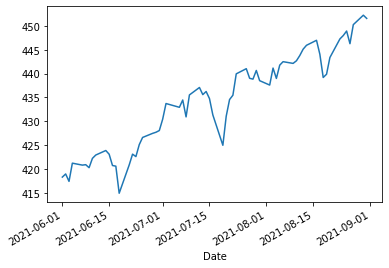

In [575]:
sp_price.loc[start_date: end_date,'Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

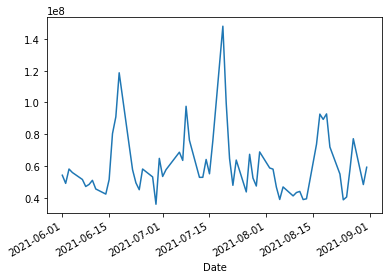

In [576]:
sp_price.loc[start_date:end_date,'Volume'].plot()

In [577]:
# Lets look at the difference between the daily high and daily low

sp_price['high_minus_low'] = sp_price['High'] - sp_price['Low']
sp_price['high_minus_low_pct_adjclose'] = (sp_price['High'] - sp_price['Low'])/sp_price['Adj Close'] * 100

sp_price.head()

,Open,High,Low,Close,Adj Close,Volume,high_minus_low,high_minus_low_pct_adjclose
Date,,,,,,,,
2019-01-02,245.979996,251.210007,245.949997,250.179993,239.459229,126925200,5.260010,2.196620
2019-01-03,248.229996,248.570007,243.669998,244.210007,233.745056,144140700,4.900009,2.096305
2019-01-04,247.589996,253.110001,247.169998,252.389999,241.574493,142628800,5.940002,2.458870
2019-01-07,252.690002,255.949997,251.690002,254.380005,243.479263,103139100,4.259995,1.749633
2019-01-08,256.820007,257.309998,254.000000,256.769989,245.766846,102512600,3.309998,1.346804


(array([305., 222.,  69.,  34.,  16.,  12.,   5.,   3.,   5.,   1.]),
 array([ 0.58999634,  2.82699738,  5.06399841,  7.30099945,  9.53800049,
        11.77500153, 14.01200256, 16.2490036 , 18.48600464, 20.72300568,
        22.96000671]),
 [<matplotlib.patches.Polygon at 0x7fba826d3850>])

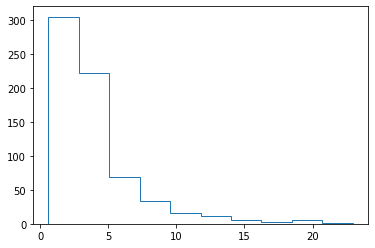

In [578]:
# Plot distribution of high_minus_low_pct

plt.hist(sp_price['high_minus_low'], histtype='step')

(array([379., 191.,  47.,  23.,  15.,   4.,   4.,   2.,   4.,   3.]),
 array([0.18833059, 1.04363052, 1.89893045, 2.75423038, 3.60953031,
        4.46483023, 5.32013016, 6.17543009, 7.03073002, 7.88602995,
        8.74132988]),
 [<matplotlib.patches.Polygon at 0x7fbaa44a6610>])

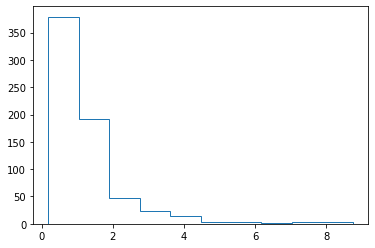

In [579]:
# Plot distribution of high_minus_low_pct

plt.hist(sp_price['high_minus_low_pct_adjclose'], histtype='step')

<AxesSubplot:xlabel='Date'>

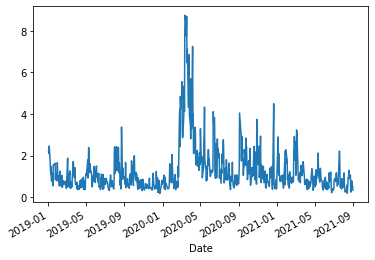

In [580]:
# Plot time series of high_minus_low_pct

sp_price['high_minus_low_pct_adjclose'].plot()

#### 2.1.4.1 SP500 Time Series Feature Engineering<a id='2.1.4.1_sp_ts_feature_eng'></a>

In [581]:
sp_price['lagged_1'] = sp_price['Adj Close'].shift(-1)     # create 1 day lag variable
sp_price['lagged_5'] = sp_price['Adj Close'].shift(-5)     # create 5 day lag variable
sp_price['lagged_10'] = sp_price['Adj Close'].shift(-10)   # create 10 day lag variable
sp_price['lagged_20'] = sp_price['Adj Close'].shift(-20)   # create 20 day lag variable

# Create shifted variables

sp_price['shifted_1'] = sp_price['Adj Close'].shift(1)     # create 1 day shifted variable
sp_price['shifted_5'] = sp_price['Adj Close'].shift(5)     # create 5 day shifted variable
sp_price['shifted_10'] = sp_price['Adj Close'].shift(10)   # create 10 day shifted variable
sp_price['shifted_20'] = sp_price['Adj Close'].shift(20)   # create 20 day shifted variable

# Calculate returns

sp_price['pct_change_1'] = sp_price['Adj Close'].pct_change(1).mul(100)     
sp_price['pct_change_5'] = sp_price['Adj Close'].pct_change(5).mul(100)     
sp_price['pct_change_10'] = sp_price['Adj Close'].pct_change(10).mul(100)   
sp_price['pct_change_20'] = sp_price['Adj Close'].pct_change(20).mul(100)


# Calculate returns using div.sub.mul method
# this line was to test another method of calculating
#sp_price['div_sub_20'] = sp_price['Adj Close'].div(sp_price['shifted_20']).sub(1).mul(100)

# Rolling window metrics, these moving averages are typically important to technical traders

sp_price['50_ma'] = sp_price['Adj Close'].rolling(window=50).mean()
sp_price['100_ma'] = sp_price['Adj Close'].rolling(window=100).mean()
sp_price['200_ma'] = sp_price['Adj Close'].rolling(window=200).mean()

# Rolling window metrics, moving standard deviation 

sp_price['50_std'] = sp_price['Adj Close'].rolling(window=50).std()
sp_price['100_std'] = sp_price['Adj Close'].rolling(window=100).std()
sp_price['200_std'] = sp_price['Adj Close'].rolling(window=200).std()

# Cumulative return

sp_price['cumulative_return'] = sp_price['Adj Close'].pct_change(1).add(1).cumprod().sub(1).mul(100)

In [582]:
sp_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-01-02 to 2021-08-31
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Open                         672 non-null    float64
 1   High                         672 non-null    float64
 2   Low                          672 non-null    float64
 3   Close                        672 non-null    float64
 4   Adj Close                    672 non-null    float64
 5   Volume                       672 non-null    int64  
 6   high_minus_low               672 non-null    float64
 7   high_minus_low_pct_adjclose  672 non-null    float64
 8   lagged_1                     671 non-null    float64
 9   lagged_5                     667 non-null    float64
 10  lagged_10                    662 non-null    float64
 11  lagged_20                    652 non-null    float64
 12  shifted_1                    671 non-null    float64
 13  s

In [583]:
sp_price['up_or_down'] = sp_price['pct_change_1'].apply(lambda x: up_down_days(x))
pd.concat([sp_price['up_or_down'].value_counts(), sp_price['up_or_down'].value_counts()/sp_price['up_or_down'].value_counts().sum()], axis=1) 

,up_or_down,up_or_down
UP,393,0.584821
DOWN,279,0.415179


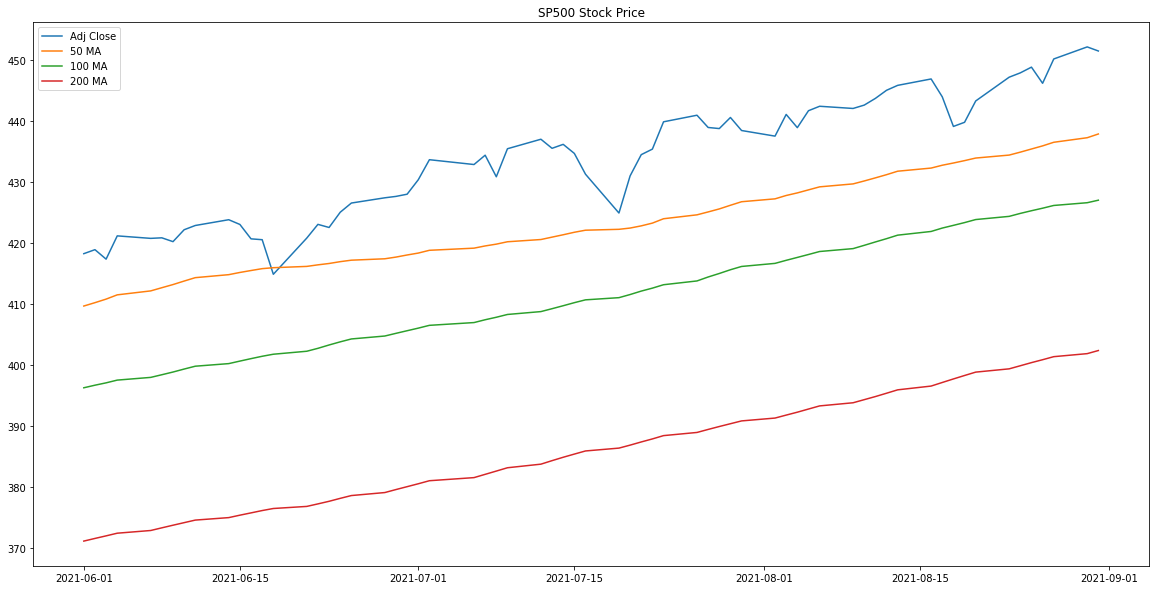

In [584]:
# Plot price vs moving averages with custom date range
plt.figure(figsize=(20,10))

plt.plot(sp_price.loc[start_date:end_date,['Adj Close', '50_ma', '100_ma', '200_ma']])
plt.title('SP500 Stock Price')
plt.legend(['Adj Close', '50 MA', '100 MA', '200 MA'])

There are more up days than down days

We would like to create a column that counts the consecutive up and down days. We can use this to get a distribution of the consecutive up days and down days for the S&P 500

In [585]:
# create column with count of consecutive up and down days

sp_price['consecutive_count'] = sp_price.groupby((sp_price['up_or_down'] != sp_price['up_or_down'].shift(1)).cumsum()).cumcount() + 1

<AxesSubplot:>

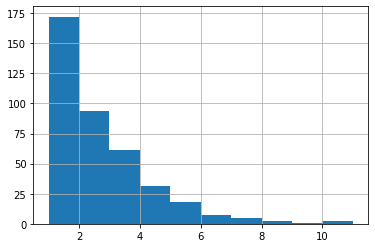

In [586]:
sp_price.loc[sp_price['up_or_down'] == 'UP', 'consecutive_count'].hist()

Next we need to identify the number of single day gains and consecurive day gains without double counting.

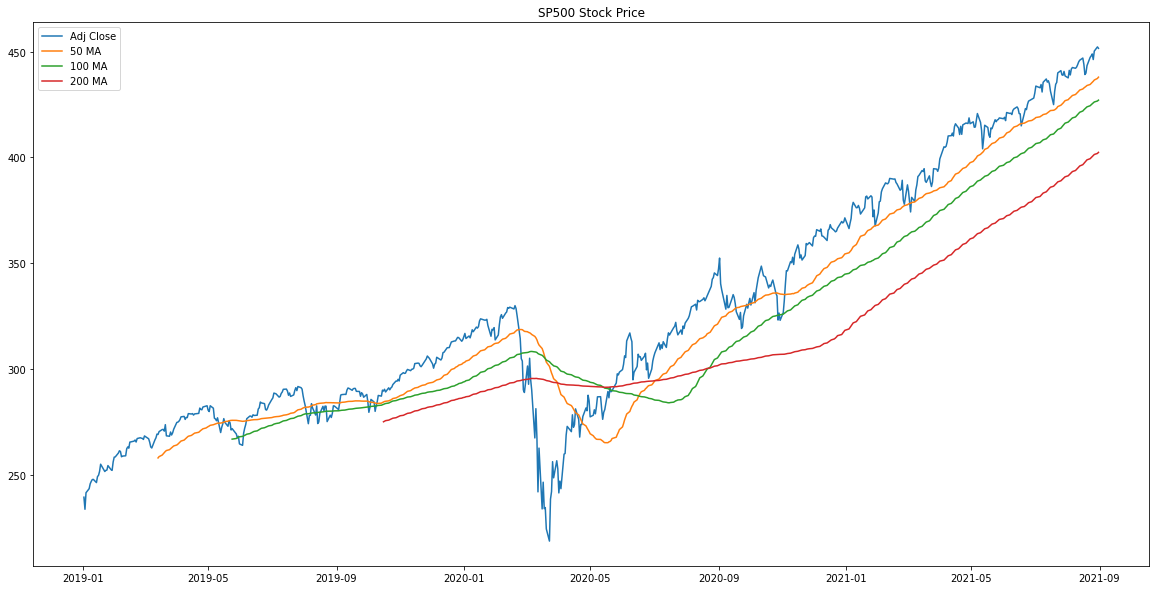

In [587]:
# Plot price vs moving averages
plt.figure(figsize=(20,10))

plt.plot(sp_price[['Adj Close', '50_ma', '100_ma', '200_ma']])
plt.title('SP500 Stock Price')
plt.legend(['Adj Close', '50 MA', '100 MA', '200 MA'])

Here we see a lot of resistance at the 50 day moving average level and we can see that when the 50 day moving average crossed below the 100 day moving average, the market moved lower by a large margin. By the time the 100 day moving average crossed below the 200 day moving average, we can see that the recovery had already taken place.

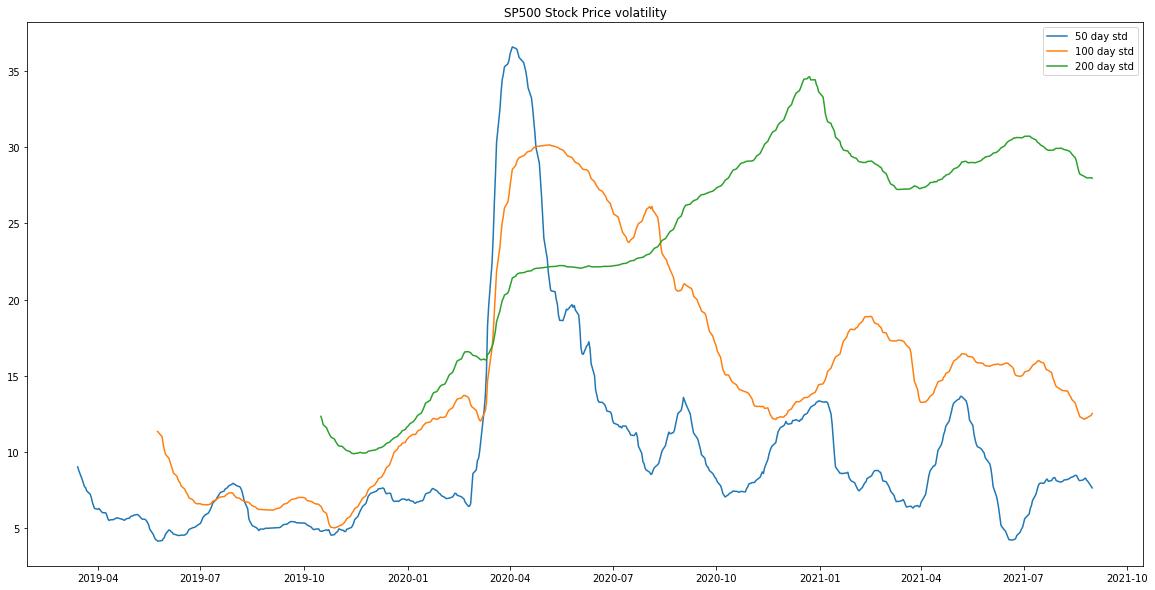

In [588]:
# Plot price vs moving averages
plt.figure(figsize=(20,10))

plt.plot(sp_price[['50_std', '100_std', '200_std']])
plt.title('SP500 Stock Price volatility')
plt.legend(['50 day std', '100 day std', '200 day std'])

In [589]:
# export sp_price

sp_price.to_csv('sp_price.csv')

## 3.1 Resources to Review for future analysis<a id='3.1_resources'></a>

Datacamp Courses to look at:

For time series:
   
   * Manpulating Time Series Data in Python (**Completed first 3 chapters**)
   * Time Series Analysis in Python
   * ARIMA Models in Python
   * GARCH Models in Python
   * Machine Learning for Time Series Data in Python
   
For Twitter Sentiment Analysis

   * Analyzing Social Media Data in Python (**Completed first 2 chapters**)
   * Sentiment Analysis in Python

## Analysis to-do list

For Twitter Sentiment Analysis

   * Do a word count of SP500, JD and buy, sell etc...
   * Do sentiment analysis with polarity scores (**complete**)
   * Conditional Rolling review (https://stackoverflow.com/questions/25119524/pandas-conditional-rolling-count)